This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
custom_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/custom_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
custom_aggregated_data_pca = pd.read_parquet(custom_aggregated_data_pca_path)
print(custom_aggregated_data_pca.shape)
custom_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-5.798417,3.829101,0.235508,-1.891659,0.269128,-9.286478,0.547681,...,-0.139746,-0.028435,-0.108986,-0.061343,0.107011,0.070422,0.098300,0.014989,-0.047070,3.680084e-15
1,High-Severity,1,R,-0.147725,-7.333535,-1.375084,-1.299879,-1.557402,2.658578,-3.362463,...,0.589385,-0.512889,-0.181329,-0.033345,0.105213,0.181050,0.098753,0.059413,-0.146195,-7.507207e-16
2,High-Severity,10,L,4.244648,-10.919777,-2.979601,-2.539290,0.374291,4.635479,0.642153,...,0.040760,0.119014,0.649102,0.140987,0.034728,0.078310,-0.177995,-0.188239,-0.270704,-9.132831e-17
3,High-Severity,10,R,1.115032,-5.931238,-2.604917,0.476947,-0.520816,3.033154,-2.047205,...,-0.536821,-0.319381,0.253793,0.032361,-0.058072,-0.538296,-0.421887,0.068166,0.085418,1.085143e-16
4,High-Severity,11,L,0.485280,-8.943044,0.981028,-0.914526,0.630209,-6.363313,0.711778,...,-0.066315,-0.109219,0.183489,0.048739,-0.056860,-0.120726,0.008437,-0.003078,-0.014906,9.784586e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 18.401314906445336


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 10.855720066737538


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 12.4934895144469


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                | 1/1000 [00:00<02:50,  5.86it/s]

  0%|▎                                                                                                                                | 2/1000 [00:00<02:52,  5.80it/s]

  0%|▍                                                                                                                                | 3/1000 [00:00<02:51,  5.80it/s]

  0%|▌                                                                                                                                | 4/1000 [00:00<02:51,  5.80it/s]

  0%|▋                                                                                                                                | 5/1000 [00:00<02:51,  5.80it/s]

  1%|▊                                                                                                                                | 6/1000 [00:01<02:51,  5.81it/s]

  1%|▉                                                                                                                                | 7/1000 [00:01<02:50,  5.81it/s]

  1%|█                                                                                                                                | 8/1000 [00:01<02:51,  5.78it/s]

  1%|█▏                                                                                                                               | 9/1000 [00:01<02:51,  5.77it/s]

  1%|█▎                                                                                                                              | 10/1000 [00:01<02:51,  5.78it/s]

  1%|█▍                                                                                                                              | 11/1000 [00:01<02:51,  5.78it/s]

  1%|█▌                                                                                                                              | 12/1000 [00:02<02:51,  5.77it/s]

  1%|█▋                                                                                                                              | 13/1000 [00:02<02:51,  5.75it/s]

  1%|█▊                                                                                                                              | 14/1000 [00:02<02:51,  5.77it/s]

  2%|█▉                                                                                                                              | 15/1000 [00:02<02:51,  5.75it/s]

  2%|██                                                                                                                              | 16/1000 [00:02<02:51,  5.75it/s]

  2%|██▏                                                                                                                             | 17/1000 [00:02<02:50,  5.76it/s]

  2%|██▎                                                                                                                             | 18/1000 [00:03<02:50,  5.78it/s]

  2%|██▍                                                                                                                             | 19/1000 [00:03<02:50,  5.77it/s]

  2%|██▌                                                                                                                             | 20/1000 [00:03<02:50,  5.76it/s]

  2%|██▋                                                                                                                             | 21/1000 [00:03<02:49,  5.76it/s]

  2%|██▊                                                                                                                             | 22/1000 [00:03<02:49,  5.76it/s]

  2%|██▉                                                                                                                             | 23/1000 [00:03<02:49,  5.76it/s]

  2%|███                                                                                                                             | 24/1000 [00:04<02:49,  5.77it/s]

  2%|███▏                                                                                                                            | 25/1000 [00:04<02:49,  5.77it/s]

  3%|███▎                                                                                                                            | 26/1000 [00:04<02:48,  5.77it/s]

  3%|███▍                                                                                                                            | 27/1000 [00:04<02:48,  5.78it/s]

  3%|███▌                                                                                                                            | 28/1000 [00:04<02:47,  5.79it/s]

  3%|███▋                                                                                                                            | 29/1000 [00:05<03:09,  5.13it/s]

  3%|███▊                                                                                                                            | 30/1000 [00:05<03:02,  5.31it/s]

  3%|███▉                                                                                                                            | 31/1000 [00:05<02:57,  5.45it/s]

  3%|████                                                                                                                            | 32/1000 [00:05<02:54,  5.54it/s]

  3%|████▏                                                                                                                           | 33/1000 [00:05<02:52,  5.61it/s]

  3%|████▎                                                                                                                           | 34/1000 [00:05<02:50,  5.65it/s]

  4%|████▍                                                                                                                           | 35/1000 [00:06<02:49,  5.71it/s]

  4%|████▌                                                                                                                           | 36/1000 [00:06<02:48,  5.72it/s]

  4%|████▋                                                                                                                           | 37/1000 [00:06<02:47,  5.74it/s]

  4%|████▊                                                                                                                           | 38/1000 [00:06<02:47,  5.75it/s]

  4%|████▉                                                                                                                           | 39/1000 [00:06<02:46,  5.76it/s]

  4%|█████                                                                                                                           | 40/1000 [00:06<02:46,  5.76it/s]

  4%|█████▏                                                                                                                          | 41/1000 [00:07<02:46,  5.76it/s]

  4%|█████▍                                                                                                                          | 42/1000 [00:07<02:46,  5.76it/s]

  4%|█████▌                                                                                                                          | 43/1000 [00:07<02:46,  5.75it/s]

  4%|█████▋                                                                                                                          | 44/1000 [00:07<02:46,  5.75it/s]

  4%|█████▊                                                                                                                          | 45/1000 [00:07<02:45,  5.76it/s]

  5%|█████▉                                                                                                                          | 46/1000 [00:08<02:45,  5.77it/s]

  5%|██████                                                                                                                          | 47/1000 [00:08<02:45,  5.77it/s]

  5%|██████▏                                                                                                                         | 48/1000 [00:08<02:44,  5.77it/s]

  5%|██████▎                                                                                                                         | 49/1000 [00:08<02:44,  5.77it/s]

  5%|██████▍                                                                                                                         | 50/1000 [00:08<02:44,  5.77it/s]

  5%|██████▌                                                                                                                         | 51/1000 [00:08<02:44,  5.78it/s]

  5%|██████▋                                                                                                                         | 52/1000 [00:09<02:43,  5.79it/s]

  5%|██████▊                                                                                                                         | 53/1000 [00:09<02:43,  5.78it/s]

  5%|██████▉                                                                                                                         | 54/1000 [00:09<02:43,  5.78it/s]

  6%|███████                                                                                                                         | 55/1000 [00:09<02:43,  5.78it/s]

  6%|███████▏                                                                                                                        | 56/1000 [00:09<02:43,  5.77it/s]

  6%|███████▎                                                                                                                        | 57/1000 [00:09<02:43,  5.77it/s]

  6%|███████▍                                                                                                                        | 58/1000 [00:10<02:43,  5.76it/s]

  6%|███████▌                                                                                                                        | 59/1000 [00:10<02:43,  5.77it/s]

  6%|███████▋                                                                                                                        | 60/1000 [00:10<02:43,  5.76it/s]

  6%|███████▊                                                                                                                        | 61/1000 [00:10<02:43,  5.76it/s]

  6%|███████▉                                                                                                                        | 62/1000 [00:10<02:43,  5.75it/s]

  6%|████████                                                                                                                        | 63/1000 [00:10<02:42,  5.76it/s]

  6%|████████▏                                                                                                                       | 64/1000 [00:11<02:42,  5.76it/s]

  6%|████████▎                                                                                                                       | 65/1000 [00:11<02:42,  5.75it/s]

  7%|████████▍                                                                                                                       | 66/1000 [00:11<02:42,  5.76it/s]

  7%|████████▌                                                                                                                       | 67/1000 [00:11<02:42,  5.75it/s]

  7%|████████▋                                                                                                                       | 68/1000 [00:11<02:41,  5.75it/s]

  7%|████████▊                                                                                                                       | 69/1000 [00:12<02:41,  5.75it/s]

  7%|████████▉                                                                                                                       | 70/1000 [00:12<02:41,  5.76it/s]

  7%|█████████                                                                                                                       | 71/1000 [00:12<02:41,  5.76it/s]

  7%|█████████▏                                                                                                                      | 72/1000 [00:12<02:41,  5.76it/s]

  7%|█████████▎                                                                                                                      | 73/1000 [00:12<02:41,  5.76it/s]

  7%|█████████▍                                                                                                                      | 74/1000 [00:12<02:40,  5.76it/s]

  8%|█████████▌                                                                                                                      | 75/1000 [00:13<02:40,  5.77it/s]

  8%|█████████▋                                                                                                                      | 76/1000 [00:13<02:40,  5.76it/s]

  8%|█████████▊                                                                                                                      | 77/1000 [00:13<02:40,  5.76it/s]

  8%|█████████▉                                                                                                                      | 78/1000 [00:13<02:40,  5.75it/s]

  8%|██████████                                                                                                                      | 79/1000 [00:13<02:40,  5.75it/s]

  8%|██████████▏                                                                                                                     | 80/1000 [00:13<02:39,  5.75it/s]

  8%|██████████▎                                                                                                                     | 81/1000 [00:14<02:45,  5.55it/s]

  8%|██████████▍                                                                                                                     | 82/1000 [00:14<02:43,  5.61it/s]

  8%|██████████▌                                                                                                                     | 83/1000 [00:14<02:45,  5.55it/s]

  8%|██████████▊                                                                                                                     | 84/1000 [00:14<02:44,  5.58it/s]

  8%|██████████▉                                                                                                                     | 85/1000 [00:14<02:42,  5.63it/s]

  9%|███████████                                                                                                                     | 86/1000 [00:15<02:41,  5.67it/s]

  9%|███████████▏                                                                                                                    | 87/1000 [00:15<02:40,  5.70it/s]

  9%|███████████▎                                                                                                                    | 88/1000 [00:15<02:39,  5.72it/s]

  9%|███████████▍                                                                                                                    | 89/1000 [00:15<02:38,  5.73it/s]

  9%|███████████▌                                                                                                                    | 90/1000 [00:15<02:38,  5.74it/s]

  9%|███████████▋                                                                                                                    | 91/1000 [00:15<02:38,  5.75it/s]

  9%|███████████▊                                                                                                                    | 92/1000 [00:16<02:37,  5.76it/s]

  9%|███████████▉                                                                                                                    | 93/1000 [00:16<02:37,  5.76it/s]

  9%|████████████                                                                                                                    | 94/1000 [00:16<02:37,  5.77it/s]

 10%|████████████▏                                                                                                                   | 95/1000 [00:16<02:37,  5.76it/s]

 10%|████████████▎                                                                                                                   | 96/1000 [00:16<02:37,  5.76it/s]

 10%|████████████▍                                                                                                                   | 97/1000 [00:16<02:36,  5.76it/s]

 10%|████████████▌                                                                                                                   | 98/1000 [00:17<02:36,  5.77it/s]

 10%|████████████▋                                                                                                                   | 99/1000 [00:17<02:36,  5.77it/s]

 10%|████████████▋                                                                                                                  | 100/1000 [00:17<02:35,  5.77it/s]

 10%|████████████▊                                                                                                                  | 101/1000 [00:17<02:35,  5.77it/s]

 10%|████████████▉                                                                                                                  | 102/1000 [00:17<02:35,  5.77it/s]

 10%|█████████████                                                                                                                  | 103/1000 [00:17<02:35,  5.76it/s]

 10%|█████████████▏                                                                                                                 | 104/1000 [00:18<02:35,  5.77it/s]

 10%|█████████████▎                                                                                                                 | 105/1000 [00:18<02:35,  5.75it/s]

 11%|█████████████▍                                                                                                                 | 106/1000 [00:18<02:35,  5.76it/s]

 11%|█████████████▌                                                                                                                 | 107/1000 [00:18<02:35,  5.76it/s]

 11%|█████████████▋                                                                                                                 | 108/1000 [00:18<02:34,  5.76it/s]

 11%|█████████████▊                                                                                                                 | 109/1000 [00:19<02:34,  5.75it/s]

 11%|█████████████▉                                                                                                                 | 110/1000 [00:19<02:34,  5.75it/s]

 11%|██████████████                                                                                                                 | 111/1000 [00:19<02:34,  5.76it/s]

 11%|██████████████▏                                                                                                                | 112/1000 [00:19<02:35,  5.72it/s]

 11%|██████████████▎                                                                                                                | 113/1000 [00:19<02:34,  5.73it/s]

 11%|██████████████▍                                                                                                                | 114/1000 [00:19<02:37,  5.64it/s]

 12%|██████████████▌                                                                                                                | 115/1000 [00:20<02:40,  5.52it/s]

 12%|██████████████▋                                                                                                                | 116/1000 [00:20<02:39,  5.53it/s]

 12%|██████████████▊                                                                                                                | 117/1000 [00:20<02:37,  5.61it/s]

 12%|██████████████▉                                                                                                                | 118/1000 [00:20<02:37,  5.59it/s]

 12%|███████████████                                                                                                                | 119/1000 [00:20<02:37,  5.61it/s]

 12%|███████████████▏                                                                                                               | 120/1000 [00:20<02:36,  5.64it/s]

 12%|███████████████▎                                                                                                               | 121/1000 [00:21<02:34,  5.68it/s]

 12%|███████████████▍                                                                                                               | 122/1000 [00:21<02:33,  5.70it/s]

 12%|███████████████▌                                                                                                               | 123/1000 [00:21<02:33,  5.72it/s]

 12%|███████████████▋                                                                                                               | 124/1000 [00:21<02:32,  5.73it/s]

 12%|███████████████▉                                                                                                               | 125/1000 [00:21<02:32,  5.74it/s]

 13%|████████████████                                                                                                               | 126/1000 [00:22<02:32,  5.75it/s]

 13%|████████████████▏                                                                                                              | 127/1000 [00:22<02:31,  5.75it/s]

 13%|████████████████▎                                                                                                              | 128/1000 [00:22<02:32,  5.71it/s]

 13%|████████████████▍                                                                                                              | 129/1000 [00:22<02:35,  5.59it/s]

 13%|████████████████▌                                                                                                              | 130/1000 [00:22<02:34,  5.64it/s]

 13%|████████████████▋                                                                                                              | 131/1000 [00:22<02:23,  6.04it/s]

 13%|████████████████▊                                                                                                              | 132/1000 [00:23<02:31,  5.74it/s]

 13%|████████████████▉                                                                                                              | 133/1000 [00:23<02:37,  5.51it/s]

 13%|█████████████████                                                                                                              | 134/1000 [00:23<02:35,  5.58it/s]

 14%|█████████████████▏                                                                                                             | 135/1000 [00:23<02:36,  5.52it/s]

 14%|█████████████████▎                                                                                                             | 136/1000 [00:23<02:38,  5.44it/s]

 14%|█████████████████▍                                                                                                             | 137/1000 [00:23<02:41,  5.35it/s]

 14%|█████████████████▌                                                                                                             | 138/1000 [00:24<02:55,  4.92it/s]

 14%|█████████████████▋                                                                                                             | 139/1000 [00:24<03:17,  4.37it/s]

 14%|█████████████████▊                                                                                                             | 140/1000 [00:24<03:46,  3.80it/s]

 14%|█████████████████▉                                                                                                             | 141/1000 [00:25<03:48,  3.76it/s]

 14%|██████████████████                                                                                                             | 142/1000 [00:25<03:31,  4.07it/s]

 14%|██████████████████▏                                                                                                            | 143/1000 [00:25<03:18,  4.32it/s]

 14%|██████████████████▎                                                                                                            | 144/1000 [00:25<03:10,  4.49it/s]

 14%|██████████████████▍                                                                                                            | 145/1000 [00:25<03:03,  4.66it/s]

 15%|██████████████████▌                                                                                                            | 146/1000 [00:26<02:54,  4.90it/s]

 15%|██████████████████▋                                                                                                            | 147/1000 [00:26<02:51,  4.98it/s]

 15%|██████████████████▊                                                                                                            | 148/1000 [00:26<03:05,  4.58it/s]

 15%|██████████████████▉                                                                                                            | 149/1000 [00:26<02:57,  4.78it/s]

 15%|███████████████████                                                                                                            | 150/1000 [00:26<02:55,  4.83it/s]

 15%|███████████████████▏                                                                                                           | 151/1000 [00:27<02:49,  5.01it/s]

 15%|███████████████████▎                                                                                                           | 152/1000 [00:27<02:59,  4.74it/s]

 15%|███████████████████▍                                                                                                           | 153/1000 [00:27<02:50,  4.98it/s]

 15%|███████████████████▌                                                                                                           | 154/1000 [00:27<02:44,  5.14it/s]

 16%|███████████████████▋                                                                                                           | 155/1000 [00:27<02:54,  4.83it/s]

 16%|███████████████████▊                                                                                                           | 156/1000 [00:28<03:05,  4.56it/s]

 16%|███████████████████▉                                                                                                           | 157/1000 [00:28<02:54,  4.83it/s]

 16%|████████████████████                                                                                                           | 158/1000 [00:28<02:47,  5.01it/s]

 16%|████████████████████▏                                                                                                          | 159/1000 [00:28<02:45,  5.09it/s]

 16%|████████████████████▎                                                                                                          | 160/1000 [00:28<02:40,  5.22it/s]

 16%|████████████████████▍                                                                                                          | 161/1000 [00:29<02:36,  5.37it/s]

 16%|████████████████████▌                                                                                                          | 162/1000 [00:29<02:35,  5.40it/s]

 16%|████████████████████▋                                                                                                          | 163/1000 [00:29<02:33,  5.44it/s]

 16%|████████████████████▊                                                                                                          | 164/1000 [00:29<02:32,  5.48it/s]

 16%|████████████████████▉                                                                                                          | 165/1000 [00:29<02:36,  5.32it/s]

 17%|█████████████████████                                                                                                          | 166/1000 [00:30<02:34,  5.39it/s]

 17%|█████████████████████▏                                                                                                         | 167/1000 [00:30<02:34,  5.41it/s]

 17%|█████████████████████▎                                                                                                         | 168/1000 [00:30<02:31,  5.50it/s]

 17%|█████████████████████▍                                                                                                         | 169/1000 [00:30<02:29,  5.55it/s]

 17%|█████████████████████▌                                                                                                         | 170/1000 [00:30<02:28,  5.60it/s]

 17%|█████████████████████▋                                                                                                         | 171/1000 [00:30<02:43,  5.07it/s]

 17%|█████████████████████▊                                                                                                         | 172/1000 [00:31<02:49,  4.90it/s]

 17%|█████████████████████▉                                                                                                         | 173/1000 [00:31<02:47,  4.94it/s]

 17%|██████████████████████                                                                                                         | 174/1000 [00:31<02:40,  5.13it/s]

 18%|██████████████████████▏                                                                                                        | 175/1000 [00:31<02:36,  5.27it/s]

 18%|██████████████████████▎                                                                                                        | 176/1000 [00:31<02:33,  5.37it/s]

 18%|██████████████████████▍                                                                                                        | 177/1000 [00:32<02:30,  5.48it/s]

 18%|██████████████████████▌                                                                                                        | 178/1000 [00:32<02:28,  5.55it/s]

 18%|██████████████████████▋                                                                                                        | 179/1000 [00:32<02:26,  5.60it/s]

 18%|██████████████████████▊                                                                                                        | 180/1000 [00:32<02:25,  5.64it/s]

 18%|██████████████████████▉                                                                                                        | 181/1000 [00:32<02:24,  5.66it/s]

 18%|███████████████████████                                                                                                        | 182/1000 [00:32<02:24,  5.67it/s]

 18%|███████████████████████▏                                                                                                       | 183/1000 [00:33<02:23,  5.70it/s]

 18%|███████████████████████▎                                                                                                       | 184/1000 [00:33<02:23,  5.68it/s]

 18%|███████████████████████▍                                                                                                       | 185/1000 [00:33<02:24,  5.62it/s]

 19%|███████████████████████▌                                                                                                       | 186/1000 [00:33<02:33,  5.32it/s]

 19%|███████████████████████▋                                                                                                       | 187/1000 [00:34<03:04,  4.40it/s]

 19%|███████████████████████▉                                                                                                       | 188/1000 [00:34<02:58,  4.54it/s]

 19%|████████████████████████                                                                                                       | 189/1000 [00:34<02:47,  4.83it/s]

 19%|████████████████████████▏                                                                                                      | 190/1000 [00:34<03:20,  4.04it/s]

 19%|████████████████████████▎                                                                                                      | 191/1000 [00:34<03:08,  4.30it/s]

 19%|████████████████████████▍                                                                                                      | 192/1000 [00:35<02:56,  4.58it/s]

 19%|████████████████████████▌                                                                                                      | 193/1000 [00:35<02:47,  4.82it/s]

 19%|████████████████████████▋                                                                                                      | 194/1000 [00:35<02:39,  5.05it/s]

 20%|████████████████████████▊                                                                                                      | 195/1000 [00:35<02:33,  5.24it/s]

 20%|████████████████████████▉                                                                                                      | 196/1000 [00:35<02:29,  5.38it/s]

 20%|█████████████████████████                                                                                                      | 197/1000 [00:36<02:26,  5.49it/s]

 20%|█████████████████████████▏                                                                                                     | 198/1000 [00:36<02:24,  5.56it/s]

 20%|█████████████████████████▎                                                                                                     | 199/1000 [00:36<02:22,  5.62it/s]

 20%|█████████████████████████▍                                                                                                     | 200/1000 [00:36<02:21,  5.66it/s]

 20%|█████████████████████████▌                                                                                                     | 201/1000 [00:36<02:20,  5.69it/s]

 20%|█████████████████████████▋                                                                                                     | 202/1000 [00:36<02:19,  5.71it/s]

 20%|█████████████████████████▊                                                                                                     | 203/1000 [00:37<02:19,  5.72it/s]

 20%|█████████████████████████▉                                                                                                     | 204/1000 [00:37<02:18,  5.73it/s]

 20%|██████████████████████████                                                                                                     | 205/1000 [00:37<02:18,  5.74it/s]

 21%|██████████████████████████▏                                                                                                    | 206/1000 [00:37<02:17,  5.75it/s]

 21%|██████████████████████████▎                                                                                                    | 207/1000 [00:37<02:17,  5.76it/s]

 21%|██████████████████████████▍                                                                                                    | 208/1000 [00:37<02:17,  5.76it/s]

 21%|██████████████████████████▌                                                                                                    | 209/1000 [00:38<02:17,  5.77it/s]

 21%|██████████████████████████▋                                                                                                    | 210/1000 [00:38<02:16,  5.77it/s]

 21%|██████████████████████████▊                                                                                                    | 211/1000 [00:38<02:16,  5.78it/s]

 21%|██████████████████████████▉                                                                                                    | 212/1000 [00:38<02:16,  5.77it/s]

 21%|███████████████████████████                                                                                                    | 213/1000 [00:38<02:16,  5.76it/s]

 21%|███████████████████████████▏                                                                                                   | 214/1000 [00:38<02:16,  5.76it/s]

 22%|███████████████████████████▎                                                                                                   | 215/1000 [00:39<02:16,  5.77it/s]

 22%|███████████████████████████▍                                                                                                   | 216/1000 [00:39<02:15,  5.77it/s]

 22%|███████████████████████████▌                                                                                                   | 217/1000 [00:39<02:15,  5.77it/s]

 22%|███████████████████████████▋                                                                                                   | 218/1000 [00:39<02:15,  5.75it/s]

 22%|███████████████████████████▊                                                                                                   | 219/1000 [00:39<02:21,  5.51it/s]

 22%|███████████████████████████▉                                                                                                   | 220/1000 [00:40<02:19,  5.58it/s]

 22%|████████████████████████████                                                                                                   | 221/1000 [00:40<02:18,  5.62it/s]

 22%|████████████████████████████▏                                                                                                  | 222/1000 [00:40<02:17,  5.65it/s]

 22%|████████████████████████████▎                                                                                                  | 223/1000 [00:40<02:16,  5.69it/s]

 22%|████████████████████████████▍                                                                                                  | 224/1000 [00:40<02:15,  5.71it/s]

 22%|████████████████████████████▌                                                                                                  | 225/1000 [00:40<02:15,  5.73it/s]

 23%|████████████████████████████▋                                                                                                  | 226/1000 [00:41<02:14,  5.75it/s]

 23%|████████████████████████████▊                                                                                                  | 227/1000 [00:41<02:14,  5.75it/s]

 23%|████████████████████████████▉                                                                                                  | 228/1000 [00:41<02:14,  5.75it/s]

 23%|█████████████████████████████                                                                                                  | 229/1000 [00:41<02:13,  5.76it/s]

 23%|█████████████████████████████▏                                                                                                 | 230/1000 [00:41<02:13,  5.76it/s]

 23%|█████████████████████████████▎                                                                                                 | 231/1000 [00:41<02:13,  5.77it/s]

 23%|█████████████████████████████▍                                                                                                 | 232/1000 [00:42<02:13,  5.77it/s]

 23%|█████████████████████████████▌                                                                                                 | 233/1000 [00:42<02:13,  5.76it/s]

 23%|█████████████████████████████▋                                                                                                 | 234/1000 [00:42<02:12,  5.76it/s]

 24%|█████████████████████████████▊                                                                                                 | 235/1000 [00:42<02:12,  5.77it/s]

 24%|█████████████████████████████▉                                                                                                 | 236/1000 [00:42<02:12,  5.77it/s]

 24%|██████████████████████████████                                                                                                 | 237/1000 [00:43<02:12,  5.77it/s]

 24%|██████████████████████████████▏                                                                                                | 238/1000 [00:43<02:14,  5.67it/s]

 24%|██████████████████████████████▎                                                                                                | 239/1000 [00:43<02:14,  5.66it/s]

 24%|██████████████████████████████▍                                                                                                | 240/1000 [00:43<02:13,  5.67it/s]

 24%|██████████████████████████████▌                                                                                                | 241/1000 [00:43<02:13,  5.71it/s]

 24%|██████████████████████████████▋                                                                                                | 242/1000 [00:43<02:13,  5.68it/s]

 24%|██████████████████████████████▊                                                                                                | 243/1000 [00:44<02:12,  5.70it/s]

 24%|██████████████████████████████▉                                                                                                | 244/1000 [00:44<02:12,  5.71it/s]

 24%|███████████████████████████████                                                                                                | 245/1000 [00:44<02:12,  5.70it/s]

 25%|███████████████████████████████▏                                                                                               | 246/1000 [00:44<02:12,  5.71it/s]

 25%|███████████████████████████████▎                                                                                               | 247/1000 [00:44<02:11,  5.72it/s]

 25%|███████████████████████████████▍                                                                                               | 248/1000 [00:44<02:11,  5.73it/s]

 25%|███████████████████████████████▌                                                                                               | 249/1000 [00:45<02:10,  5.74it/s]

 25%|███████████████████████████████▊                                                                                               | 250/1000 [00:45<02:10,  5.73it/s]

 25%|███████████████████████████████▉                                                                                               | 251/1000 [00:45<02:10,  5.74it/s]

 25%|████████████████████████████████                                                                                               | 252/1000 [00:45<02:11,  5.70it/s]

 25%|████████████████████████████████▏                                                                                              | 253/1000 [00:45<02:10,  5.72it/s]

 25%|████████████████████████████████▎                                                                                              | 254/1000 [00:45<02:10,  5.72it/s]

 26%|████████████████████████████████▍                                                                                              | 255/1000 [00:46<02:09,  5.73it/s]

 26%|████████████████████████████████▌                                                                                              | 256/1000 [00:46<02:10,  5.71it/s]

 26%|████████████████████████████████▋                                                                                              | 257/1000 [00:46<02:09,  5.72it/s]

 26%|████████████████████████████████▊                                                                                              | 258/1000 [00:46<02:09,  5.73it/s]

 26%|████████████████████████████████▉                                                                                              | 259/1000 [00:46<02:09,  5.73it/s]

 26%|█████████████████████████████████                                                                                              | 260/1000 [00:47<02:08,  5.74it/s]

 26%|█████████████████████████████████▏                                                                                             | 261/1000 [00:47<02:08,  5.74it/s]

 26%|█████████████████████████████████▎                                                                                             | 262/1000 [00:47<02:08,  5.73it/s]

 26%|█████████████████████████████████▍                                                                                             | 263/1000 [00:47<02:08,  5.73it/s]

 26%|█████████████████████████████████▌                                                                                             | 264/1000 [00:47<02:08,  5.74it/s]

 26%|█████████████████████████████████▋                                                                                             | 265/1000 [00:47<02:08,  5.74it/s]

 27%|█████████████████████████████████▊                                                                                             | 266/1000 [00:48<02:08,  5.73it/s]

 27%|█████████████████████████████████▉                                                                                             | 267/1000 [00:48<02:07,  5.74it/s]

 27%|██████████████████████████████████                                                                                             | 268/1000 [00:48<02:07,  5.74it/s]

 27%|██████████████████████████████████▏                                                                                            | 269/1000 [00:48<02:07,  5.74it/s]

 27%|██████████████████████████████████▎                                                                                            | 270/1000 [00:48<02:07,  5.74it/s]

 27%|██████████████████████████████████▍                                                                                            | 271/1000 [00:48<02:07,  5.74it/s]

 27%|██████████████████████████████████▌                                                                                            | 272/1000 [00:49<02:06,  5.75it/s]

 27%|██████████████████████████████████▋                                                                                            | 273/1000 [00:49<02:06,  5.75it/s]

 27%|██████████████████████████████████▊                                                                                            | 274/1000 [00:49<02:06,  5.75it/s]

 28%|██████████████████████████████████▉                                                                                            | 275/1000 [00:49<02:06,  5.74it/s]

 28%|███████████████████████████████████                                                                                            | 276/1000 [00:49<02:06,  5.74it/s]

 28%|███████████████████████████████████▏                                                                                           | 277/1000 [00:50<02:05,  5.74it/s]

 28%|███████████████████████████████████▎                                                                                           | 278/1000 [00:50<02:05,  5.76it/s]

 28%|███████████████████████████████████▍                                                                                           | 279/1000 [00:50<02:05,  5.76it/s]

 28%|███████████████████████████████████▌                                                                                           | 280/1000 [00:50<02:05,  5.72it/s]

 28%|███████████████████████████████████▋                                                                                           | 281/1000 [00:50<02:05,  5.73it/s]

 28%|███████████████████████████████████▊                                                                                           | 282/1000 [00:50<02:05,  5.74it/s]

 28%|███████████████████████████████████▉                                                                                           | 283/1000 [00:51<02:05,  5.73it/s]

 28%|████████████████████████████████████                                                                                           | 284/1000 [00:51<02:04,  5.74it/s]

 28%|████████████████████████████████████▏                                                                                          | 285/1000 [00:51<02:04,  5.74it/s]

 29%|████████████████████████████████████▎                                                                                          | 286/1000 [00:51<02:04,  5.74it/s]

 29%|████████████████████████████████████▍                                                                                          | 287/1000 [00:51<02:04,  5.75it/s]

 29%|████████████████████████████████████▌                                                                                          | 288/1000 [00:51<02:03,  5.75it/s]

 29%|████████████████████████████████████▋                                                                                          | 289/1000 [00:52<02:03,  5.74it/s]

 29%|████████████████████████████████████▊                                                                                          | 290/1000 [00:52<02:03,  5.74it/s]

 29%|████████████████████████████████████▉                                                                                          | 291/1000 [00:52<02:04,  5.70it/s]

 29%|█████████████████████████████████████                                                                                          | 292/1000 [00:52<02:03,  5.71it/s]

 29%|█████████████████████████████████████▏                                                                                         | 293/1000 [00:52<02:03,  5.73it/s]

 29%|█████████████████████████████████████▎                                                                                         | 294/1000 [00:52<02:03,  5.72it/s]

 30%|█████████████████████████████████████▍                                                                                         | 295/1000 [00:53<02:03,  5.73it/s]

 30%|█████████████████████████████████████▌                                                                                         | 296/1000 [00:53<02:04,  5.67it/s]

 30%|█████████████████████████████████████▋                                                                                         | 297/1000 [00:53<02:03,  5.68it/s]

 30%|█████████████████████████████████████▊                                                                                         | 298/1000 [00:53<02:03,  5.71it/s]

 30%|█████████████████████████████████████▉                                                                                         | 299/1000 [00:53<02:02,  5.72it/s]

 30%|██████████████████████████████████████                                                                                         | 300/1000 [00:54<02:03,  5.65it/s]

 30%|██████████████████████████████████████▏                                                                                        | 301/1000 [00:54<02:03,  5.67it/s]

 30%|██████████████████████████████████████▎                                                                                        | 302/1000 [00:54<02:02,  5.67it/s]

 30%|██████████████████████████████████████▍                                                                                        | 303/1000 [00:54<02:05,  5.57it/s]

 30%|██████████████████████████████████████▌                                                                                        | 304/1000 [00:54<02:03,  5.62it/s]

 30%|██████████████████████████████████████▋                                                                                        | 305/1000 [00:54<02:03,  5.65it/s]

 31%|██████████████████████████████████████▊                                                                                        | 306/1000 [00:55<02:10,  5.33it/s]

 31%|██████████████████████████████████████▉                                                                                        | 307/1000 [00:55<02:06,  5.46it/s]

 31%|███████████████████████████████████████                                                                                        | 308/1000 [00:55<02:04,  5.54it/s]

 31%|███████████████████████████████████████▏                                                                                       | 309/1000 [00:55<02:03,  5.60it/s]

 31%|███████████████████████████████████████▎                                                                                       | 310/1000 [00:55<02:02,  5.64it/s]

 31%|███████████████████████████████████████▍                                                                                       | 311/1000 [00:55<02:01,  5.66it/s]

 31%|███████████████████████████████████████▌                                                                                       | 312/1000 [00:56<02:00,  5.70it/s]

 31%|███████████████████████████████████████▊                                                                                       | 313/1000 [00:56<02:00,  5.71it/s]

 31%|███████████████████████████████████████▉                                                                                       | 314/1000 [00:56<02:00,  5.69it/s]

 32%|████████████████████████████████████████                                                                                       | 315/1000 [00:56<02:00,  5.70it/s]

 32%|████████████████████████████████████████▏                                                                                      | 316/1000 [00:56<02:00,  5.68it/s]

 32%|████████████████████████████████████████▎                                                                                      | 317/1000 [00:57<02:00,  5.69it/s]

 32%|████████████████████████████████████████▍                                                                                      | 318/1000 [00:57<02:00,  5.68it/s]

 32%|████████████████████████████████████████▌                                                                                      | 319/1000 [00:57<02:00,  5.67it/s]

 32%|████████████████████████████████████████▋                                                                                      | 320/1000 [00:57<02:03,  5.50it/s]

 32%|████████████████████████████████████████▊                                                                                      | 321/1000 [00:57<02:02,  5.55it/s]

 32%|████████████████████████████████████████▉                                                                                      | 322/1000 [00:58<02:11,  5.14it/s]

 32%|█████████████████████████████████████████                                                                                      | 323/1000 [00:58<02:42,  4.17it/s]

 32%|█████████████████████████████████████████▏                                                                                     | 324/1000 [00:58<02:33,  4.41it/s]

 32%|█████████████████████████████████████████▎                                                                                     | 325/1000 [00:58<02:34,  4.38it/s]

 33%|█████████████████████████████████████████▍                                                                                     | 326/1000 [00:58<02:22,  4.72it/s]

 33%|█████████████████████████████████████████▌                                                                                     | 327/1000 [00:59<02:15,  4.97it/s]

 33%|█████████████████████████████████████████▋                                                                                     | 328/1000 [00:59<02:09,  5.18it/s]

 33%|█████████████████████████████████████████▊                                                                                     | 329/1000 [00:59<02:05,  5.33it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 330/1000 [00:59<02:02,  5.46it/s]

 33%|██████████████████████████████████████████                                                                                     | 331/1000 [00:59<02:00,  5.54it/s]

 33%|██████████████████████████████████████████▏                                                                                    | 332/1000 [01:00<02:01,  5.48it/s]

 33%|██████████████████████████████████████████▎                                                                                    | 333/1000 [01:00<02:01,  5.50it/s]

 33%|██████████████████████████████████████████▍                                                                                    | 334/1000 [01:00<02:09,  5.15it/s]

 34%|██████████████████████████████████████████▌                                                                                    | 335/1000 [01:00<02:26,  4.54it/s]

 34%|██████████████████████████████████████████▋                                                                                    | 336/1000 [01:00<02:17,  4.83it/s]

 34%|██████████████████████████████████████████▊                                                                                    | 337/1000 [01:01<02:10,  5.07it/s]

 34%|██████████████████████████████████████████▉                                                                                    | 338/1000 [01:01<02:05,  5.26it/s]

 34%|███████████████████████████████████████████                                                                                    | 339/1000 [01:01<02:02,  5.40it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 340/1000 [01:01<01:59,  5.51it/s]

 34%|███████████████████████████████████████████▎                                                                                   | 341/1000 [01:01<01:58,  5.58it/s]

 34%|███████████████████████████████████████████▍                                                                                   | 342/1000 [01:01<01:56,  5.64it/s]

 34%|███████████████████████████████████████████▌                                                                                   | 343/1000 [01:02<01:55,  5.67it/s]

 34%|███████████████████████████████████████████▋                                                                                   | 344/1000 [01:02<01:55,  5.70it/s]

 34%|███████████████████████████████████████████▊                                                                                   | 345/1000 [01:02<01:54,  5.71it/s]

 35%|███████████████████████████████████████████▉                                                                                   | 346/1000 [01:02<01:54,  5.73it/s]

 35%|████████████████████████████████████████████                                                                                   | 347/1000 [01:02<01:53,  5.73it/s]

 35%|████████████████████████████████████████████▏                                                                                  | 348/1000 [01:02<01:53,  5.73it/s]

 35%|████████████████████████████████████████████▎                                                                                  | 349/1000 [01:03<01:53,  5.74it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 350/1000 [01:03<01:53,  5.74it/s]

 35%|████████████████████████████████████████████▌                                                                                  | 351/1000 [01:03<01:52,  5.75it/s]

 35%|████████████████████████████████████████████▋                                                                                  | 352/1000 [01:03<01:52,  5.75it/s]

 35%|████████████████████████████████████████████▊                                                                                  | 353/1000 [01:03<01:52,  5.75it/s]

 35%|████████████████████████████████████████████▉                                                                                  | 354/1000 [01:03<01:52,  5.76it/s]

 36%|█████████████████████████████████████████████                                                                                  | 355/1000 [01:04<01:52,  5.76it/s]

 36%|█████████████████████████████████████████████▏                                                                                 | 356/1000 [01:04<01:51,  5.77it/s]

 36%|█████████████████████████████████████████████▎                                                                                 | 357/1000 [01:04<01:51,  5.74it/s]

 36%|█████████████████████████████████████████████▍                                                                                 | 358/1000 [01:04<01:51,  5.76it/s]

 36%|█████████████████████████████████████████████▌                                                                                 | 359/1000 [01:04<01:51,  5.75it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 360/1000 [01:05<01:51,  5.75it/s]

 36%|█████████████████████████████████████████████▊                                                                                 | 361/1000 [01:05<01:51,  5.76it/s]

 36%|█████████████████████████████████████████████▉                                                                                 | 362/1000 [01:05<01:52,  5.69it/s]

 36%|██████████████████████████████████████████████                                                                                 | 363/1000 [01:05<01:58,  5.37it/s]

 36%|██████████████████████████████████████████████▏                                                                                | 364/1000 [01:05<02:00,  5.27it/s]

 36%|██████████████████████████████████████████████▎                                                                                | 365/1000 [01:06<02:06,  5.03it/s]

 37%|██████████████████████████████████████████████▍                                                                                | 366/1000 [01:06<02:03,  5.14it/s]

 37%|██████████████████████████████████████████████▌                                                                                | 367/1000 [01:06<02:00,  5.25it/s]

 37%|██████████████████████████████████████████████▋                                                                                | 368/1000 [01:06<01:57,  5.37it/s]

 37%|██████████████████████████████████████████████▊                                                                                | 369/1000 [01:06<01:55,  5.47it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 370/1000 [01:06<01:58,  5.34it/s]

 37%|███████████████████████████████████████████████                                                                                | 371/1000 [01:07<02:12,  4.74it/s]

 37%|███████████████████████████████████████████████▏                                                                               | 372/1000 [01:07<02:07,  4.93it/s]

 37%|███████████████████████████████████████████████▎                                                                               | 373/1000 [01:07<02:02,  5.13it/s]

 37%|███████████████████████████████████████████████▍                                                                               | 374/1000 [01:07<01:58,  5.29it/s]

 38%|███████████████████████████████████████████████▋                                                                               | 375/1000 [01:08<02:17,  4.53it/s]

 38%|███████████████████████████████████████████████▊                                                                               | 376/1000 [01:08<02:11,  4.74it/s]

 38%|███████████████████████████████████████████████▉                                                                               | 377/1000 [01:08<02:05,  4.97it/s]

 38%|████████████████████████████████████████████████                                                                               | 378/1000 [01:08<02:02,  5.08it/s]

 38%|████████████████████████████████████████████████▏                                                                              | 379/1000 [01:08<02:16,  4.56it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 380/1000 [01:09<02:08,  4.84it/s]

 38%|████████████████████████████████████████████████▍                                                                              | 381/1000 [01:09<02:01,  5.07it/s]

 38%|████████████████████████████████████████████████▌                                                                              | 382/1000 [01:09<01:58,  5.19it/s]

 38%|████████████████████████████████████████████████▋                                                                              | 383/1000 [01:09<02:33,  4.03it/s]

 38%|████████████████████████████████████████████████▊                                                                              | 384/1000 [01:09<02:19,  4.42it/s]

 38%|████████████████████████████████████████████████▉                                                                              | 385/1000 [01:10<02:09,  4.74it/s]

 39%|█████████████████████████████████████████████████                                                                              | 386/1000 [01:10<02:02,  5.01it/s]

 39%|█████████████████████████████████████████████████▏                                                                             | 387/1000 [01:10<01:56,  5.24it/s]

 39%|█████████████████████████████████████████████████▎                                                                             | 388/1000 [01:10<01:53,  5.39it/s]

 39%|█████████████████████████████████████████████████▍                                                                             | 389/1000 [01:10<01:50,  5.51it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 390/1000 [01:10<01:49,  5.58it/s]

 39%|█████████████████████████████████████████████████▋                                                                             | 391/1000 [01:11<01:48,  5.63it/s]

 39%|█████████████████████████████████████████████████▊                                                                             | 392/1000 [01:11<01:47,  5.66it/s]

 39%|█████████████████████████████████████████████████▉                                                                             | 393/1000 [01:11<01:47,  5.66it/s]

 39%|██████████████████████████████████████████████████                                                                             | 394/1000 [01:11<01:46,  5.69it/s]

 40%|██████████████████████████████████████████████████▏                                                                            | 395/1000 [01:11<01:45,  5.72it/s]

 40%|██████████████████████████████████████████████████▎                                                                            | 396/1000 [01:12<01:45,  5.73it/s]

 40%|██████████████████████████████████████████████████▍                                                                            | 397/1000 [01:12<01:44,  5.75it/s]

 40%|██████████████████████████████████████████████████▌                                                                            | 398/1000 [01:12<01:44,  5.76it/s]

 40%|██████████████████████████████████████████████████▋                                                                            | 399/1000 [01:12<01:44,  5.76it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 400/1000 [01:12<01:44,  5.76it/s]

 40%|██████████████████████████████████████████████████▉                                                                            | 401/1000 [01:12<01:43,  5.77it/s]

 40%|███████████████████████████████████████████████████                                                                            | 402/1000 [01:13<01:43,  5.77it/s]

 40%|███████████████████████████████████████████████████▏                                                                           | 403/1000 [01:13<01:43,  5.77it/s]

 40%|███████████████████████████████████████████████████▎                                                                           | 404/1000 [01:13<01:43,  5.77it/s]

 40%|███████████████████████████████████████████████████▍                                                                           | 405/1000 [01:13<01:42,  5.78it/s]

 41%|███████████████████████████████████████████████████▌                                                                           | 406/1000 [01:13<01:42,  5.78it/s]

 41%|███████████████████████████████████████████████████▋                                                                           | 407/1000 [01:13<01:42,  5.79it/s]

 41%|███████████████████████████████████████████████████▊                                                                           | 408/1000 [01:14<01:42,  5.78it/s]

 41%|███████████████████████████████████████████████████▉                                                                           | 409/1000 [01:14<01:42,  5.75it/s]

 41%|████████████████████████████████████████████████████                                                                           | 410/1000 [01:14<01:42,  5.75it/s]

 41%|████████████████████████████████████████████████████▏                                                                          | 411/1000 [01:14<01:46,  5.53it/s]

 41%|████████████████████████████████████████████████████▎                                                                          | 412/1000 [01:14<01:46,  5.50it/s]

 41%|████████████████████████████████████████████████████▍                                                                          | 413/1000 [01:15<01:45,  5.56it/s]

 41%|████████████████████████████████████████████████████▌                                                                          | 414/1000 [01:15<01:44,  5.62it/s]

 42%|████████████████████████████████████████████████████▋                                                                          | 415/1000 [01:15<01:43,  5.66it/s]

 42%|████████████████████████████████████████████████████▊                                                                          | 416/1000 [01:15<01:42,  5.69it/s]

 42%|████████████████████████████████████████████████████▉                                                                          | 417/1000 [01:15<01:42,  5.70it/s]

 42%|█████████████████████████████████████████████████████                                                                          | 418/1000 [01:15<01:41,  5.73it/s]

 42%|█████████████████████████████████████████████████████▏                                                                         | 419/1000 [01:16<01:41,  5.74it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 420/1000 [01:16<01:41,  5.74it/s]

 42%|█████████████████████████████████████████████████████▍                                                                         | 421/1000 [01:16<01:41,  5.73it/s]

 42%|█████████████████████████████████████████████████████▌                                                                         | 422/1000 [01:16<01:40,  5.73it/s]

 42%|█████████████████████████████████████████████████████▋                                                                         | 423/1000 [01:16<01:40,  5.71it/s]

 42%|█████████████████████████████████████████████████████▊                                                                         | 424/1000 [01:16<01:40,  5.73it/s]

 42%|█████████████████████████████████████████████████████▉                                                                         | 425/1000 [01:17<01:40,  5.75it/s]

 43%|██████████████████████████████████████████████████████                                                                         | 426/1000 [01:17<01:40,  5.73it/s]

 43%|██████████████████████████████████████████████████████▏                                                                        | 427/1000 [01:17<01:40,  5.73it/s]

 43%|██████████████████████████████████████████████████████▎                                                                        | 428/1000 [01:17<01:39,  5.72it/s]

 43%|██████████████████████████████████████████████████████▍                                                                        | 429/1000 [01:17<01:39,  5.73it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 430/1000 [01:17<01:39,  5.74it/s]

 43%|██████████████████████████████████████████████████████▋                                                                        | 431/1000 [01:18<01:39,  5.75it/s]

 43%|██████████████████████████████████████████████████████▊                                                                        | 432/1000 [01:18<01:38,  5.74it/s]

 43%|██████████████████████████████████████████████████████▉                                                                        | 433/1000 [01:18<01:38,  5.73it/s]

 43%|███████████████████████████████████████████████████████                                                                        | 434/1000 [01:18<01:39,  5.70it/s]

 44%|███████████████████████████████████████████████████████▏                                                                       | 435/1000 [01:18<01:38,  5.71it/s]

 44%|███████████████████████████████████████████████████████▎                                                                       | 436/1000 [01:19<01:38,  5.72it/s]

 44%|███████████████████████████████████████████████████████▍                                                                       | 437/1000 [01:19<01:38,  5.70it/s]

 44%|███████████████████████████████████████████████████████▋                                                                       | 438/1000 [01:19<01:38,  5.71it/s]

 44%|███████████████████████████████████████████████████████▊                                                                       | 439/1000 [01:19<01:38,  5.68it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 440/1000 [01:19<01:38,  5.70it/s]

 44%|████████████████████████████████████████████████████████                                                                       | 441/1000 [01:19<01:38,  5.67it/s]

 44%|████████████████████████████████████████████████████████▏                                                                      | 442/1000 [01:20<01:38,  5.68it/s]

 44%|████████████████████████████████████████████████████████▎                                                                      | 443/1000 [01:20<01:37,  5.71it/s]

 44%|████████████████████████████████████████████████████████▍                                                                      | 444/1000 [01:20<01:37,  5.73it/s]

 44%|████████████████████████████████████████████████████████▌                                                                      | 445/1000 [01:20<01:37,  5.71it/s]

 45%|████████████████████████████████████████████████████████▋                                                                      | 446/1000 [01:20<01:36,  5.72it/s]

 45%|████████████████████████████████████████████████████████▊                                                                      | 447/1000 [01:20<01:36,  5.74it/s]

 45%|████████████████████████████████████████████████████████▉                                                                      | 448/1000 [01:21<01:36,  5.73it/s]

 45%|█████████████████████████████████████████████████████████                                                                      | 449/1000 [01:21<01:36,  5.72it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 450/1000 [01:21<01:36,  5.73it/s]

 45%|█████████████████████████████████████████████████████████▎                                                                     | 451/1000 [01:21<01:35,  5.73it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                     | 452/1000 [01:21<01:35,  5.74it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                     | 453/1000 [01:22<01:36,  5.68it/s]

 45%|█████████████████████████████████████████████████████████▋                                                                     | 454/1000 [01:22<01:36,  5.64it/s]

 46%|█████████████████████████████████████████████████████████▊                                                                     | 455/1000 [01:22<01:36,  5.63it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                     | 456/1000 [01:22<01:37,  5.60it/s]

 46%|██████████████████████████████████████████████████████████                                                                     | 457/1000 [01:22<01:39,  5.48it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                    | 458/1000 [01:22<01:49,  4.94it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                    | 459/1000 [01:23<01:51,  4.85it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 460/1000 [01:23<01:49,  4.93it/s]

 46%|██████████████████████████████████████████████████████████▌                                                                    | 461/1000 [01:23<01:45,  5.13it/s]

 46%|██████████████████████████████████████████████████████████▋                                                                    | 462/1000 [01:23<01:42,  5.27it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                    | 463/1000 [01:23<01:39,  5.40it/s]

 46%|██████████████████████████████████████████████████████████▉                                                                    | 464/1000 [01:24<01:37,  5.49it/s]

 46%|███████████████████████████████████████████████████████████                                                                    | 465/1000 [01:24<01:36,  5.56it/s]

 47%|███████████████████████████████████████████████████████████▏                                                                   | 466/1000 [01:24<01:35,  5.61it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                   | 467/1000 [01:24<01:34,  5.65it/s]

 47%|███████████████████████████████████████████████████████████▍                                                                   | 468/1000 [01:24<01:33,  5.68it/s]

 47%|███████████████████████████████████████████████████████████▌                                                                   | 469/1000 [01:24<01:33,  5.70it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 470/1000 [01:25<01:45,  5.02it/s]

 47%|███████████████████████████████████████████████████████████▊                                                                   | 471/1000 [01:25<01:42,  5.18it/s]

 47%|███████████████████████████████████████████████████████████▉                                                                   | 472/1000 [01:25<01:38,  5.34it/s]

 47%|████████████████████████████████████████████████████████████                                                                   | 473/1000 [01:25<01:36,  5.46it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                  | 474/1000 [01:25<01:34,  5.55it/s]

 48%|████████████████████████████████████████████████████████████▎                                                                  | 475/1000 [01:26<01:34,  5.58it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                  | 476/1000 [01:26<01:44,  5.02it/s]

 48%|████████████████████████████████████████████████████████████▌                                                                  | 477/1000 [01:26<01:47,  4.85it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                  | 478/1000 [01:26<01:43,  5.07it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                  | 479/1000 [01:26<01:39,  5.25it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 480/1000 [01:27<01:42,  5.07it/s]

 48%|█████████████████████████████████████████████████████████████                                                                  | 481/1000 [01:27<01:38,  5.25it/s]

 48%|█████████████████████████████████████████████████████████████▏                                                                 | 482/1000 [01:27<01:36,  5.39it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 483/1000 [01:27<01:34,  5.49it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 484/1000 [01:27<01:33,  5.54it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                 | 485/1000 [01:28<01:32,  5.59it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 486/1000 [01:28<01:32,  5.58it/s]

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 487/1000 [01:28<01:32,  5.55it/s]

 49%|█████████████████████████████████████████████████████████████▉                                                                 | 488/1000 [01:28<01:32,  5.55it/s]

 49%|██████████████████████████████████████████████████████████████                                                                 | 489/1000 [01:28<01:32,  5.55it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 490/1000 [01:28<01:30,  5.61it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                                | 491/1000 [01:29<01:30,  5.65it/s]

 49%|██████████████████████████████████████████████████████████████▍                                                                | 492/1000 [01:29<01:29,  5.68it/s]

 49%|██████████████████████████████████████████████████████████████▌                                                                | 493/1000 [01:29<01:28,  5.70it/s]

 49%|██████████████████████████████████████████████████████████████▋                                                                | 494/1000 [01:29<01:28,  5.71it/s]

 50%|██████████████████████████████████████████████████████████████▊                                                                | 495/1000 [01:29<01:28,  5.72it/s]

 50%|██████████████████████████████████████████████████████████████▉                                                                | 496/1000 [01:29<01:27,  5.73it/s]

 50%|███████████████████████████████████████████████████████████████                                                                | 497/1000 [01:30<01:27,  5.72it/s]

 50%|███████████████████████████████████████████████████████████████▏                                                               | 498/1000 [01:30<01:27,  5.74it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                               | 499/1000 [01:30<01:28,  5.64it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 500/1000 [01:30<01:29,  5.60it/s]

 50%|███████████████████████████████████████████████████████████████▋                                                               | 501/1000 [01:30<01:27,  5.70it/s]

 50%|███████████████████████████████████████████████████████████████▊                                                               | 502/1000 [01:30<01:26,  5.73it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                               | 503/1000 [01:31<01:27,  5.68it/s]

 50%|████████████████████████████████████████████████████████████████                                                               | 504/1000 [01:31<01:27,  5.70it/s]

 50%|████████████████████████████████████████████████████████████████▏                                                              | 505/1000 [01:31<01:30,  5.49it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                              | 506/1000 [01:31<01:28,  5.56it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                              | 507/1000 [01:31<01:27,  5.61it/s]

 51%|████████████████████████████████████████████████████████████████▌                                                              | 508/1000 [01:32<01:27,  5.65it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                              | 509/1000 [01:32<01:26,  5.66it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 510/1000 [01:32<01:27,  5.63it/s]

 51%|████████████████████████████████████████████████████████████████▉                                                              | 511/1000 [01:32<01:27,  5.57it/s]

 51%|█████████████████████████████████████████████████████████████████                                                              | 512/1000 [01:32<01:29,  5.43it/s]

 51%|█████████████████████████████████████████████████████████████████▏                                                             | 513/1000 [01:32<01:28,  5.51it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 514/1000 [01:33<01:27,  5.58it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                             | 515/1000 [01:33<01:26,  5.62it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 516/1000 [01:33<01:25,  5.64it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 517/1000 [01:33<01:25,  5.64it/s]

 52%|█████████████████████████████████████████████████████████████████▊                                                             | 518/1000 [01:33<01:25,  5.66it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                             | 519/1000 [01:34<01:27,  5.50it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 520/1000 [01:34<01:27,  5.51it/s]

 52%|██████████████████████████████████████████████████████████████████▏                                                            | 521/1000 [01:34<01:25,  5.58it/s]

 52%|██████████████████████████████████████████████████████████████████▎                                                            | 522/1000 [01:34<01:25,  5.62it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 523/1000 [01:34<01:24,  5.64it/s]

 52%|██████████████████████████████████████████████████████████████████▌                                                            | 524/1000 [01:34<01:23,  5.67it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                            | 525/1000 [01:35<01:23,  5.69it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 526/1000 [01:35<01:22,  5.72it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 527/1000 [01:35<01:22,  5.72it/s]

 53%|███████████████████████████████████████████████████████████████████                                                            | 528/1000 [01:35<01:22,  5.73it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 529/1000 [01:35<01:22,  5.74it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 530/1000 [01:35<01:21,  5.74it/s]

 53%|███████████████████████████████████████████████████████████████████▍                                                           | 531/1000 [01:36<01:21,  5.76it/s]

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 532/1000 [01:36<01:21,  5.76it/s]

 53%|███████████████████████████████████████████████████████████████████▋                                                           | 533/1000 [01:36<01:21,  5.76it/s]

 53%|███████████████████████████████████████████████████████████████████▊                                                           | 534/1000 [01:36<01:21,  5.74it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                           | 535/1000 [01:36<01:21,  5.73it/s]

 54%|████████████████████████████████████████████████████████████████████                                                           | 536/1000 [01:37<01:21,  5.67it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                          | 537/1000 [01:37<01:21,  5.70it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 538/1000 [01:37<01:20,  5.72it/s]

 54%|████████████████████████████████████████████████████████████████████▍                                                          | 539/1000 [01:37<01:20,  5.72it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 540/1000 [01:37<01:20,  5.73it/s]

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 541/1000 [01:37<01:20,  5.72it/s]

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 542/1000 [01:38<01:22,  5.58it/s]

 54%|████████████████████████████████████████████████████████████████████▉                                                          | 543/1000 [01:38<01:29,  5.12it/s]

 54%|█████████████████████████████████████████████████████████████████████                                                          | 544/1000 [01:38<01:32,  4.94it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                         | 545/1000 [01:38<01:27,  5.18it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 546/1000 [01:38<01:24,  5.34it/s]

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 547/1000 [01:39<01:29,  5.07it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                         | 548/1000 [01:39<01:27,  5.14it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 549/1000 [01:39<01:25,  5.28it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 550/1000 [01:39<01:23,  5.41it/s]

 55%|█████████████████████████████████████████████████████████████████████▉                                                         | 551/1000 [01:39<01:26,  5.20it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                         | 552/1000 [01:40<01:23,  5.35it/s]

 55%|██████████████████████████████████████████████████████████████████████▏                                                        | 553/1000 [01:40<01:21,  5.47it/s]

 55%|██████████████████████████████████████████████████████████████████████▎                                                        | 554/1000 [01:40<01:21,  5.45it/s]

 56%|██████████████████████████████████████████████████████████████████████▍                                                        | 555/1000 [01:40<01:22,  5.39it/s]

 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 556/1000 [01:40<01:22,  5.37it/s]

 56%|██████████████████████████████████████████████████████████████████████▋                                                        | 557/1000 [01:40<01:22,  5.37it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 558/1000 [01:41<01:26,  5.09it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 559/1000 [01:41<01:25,  5.18it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 560/1000 [01:41<01:23,  5.26it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 561/1000 [01:41<01:21,  5.36it/s]

 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 562/1000 [01:41<01:22,  5.28it/s]

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 563/1000 [01:42<01:21,  5.39it/s]

 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 564/1000 [01:42<01:19,  5.50it/s]

 56%|███████████████████████████████████████████████████████████████████████▊                                                       | 565/1000 [01:42<01:18,  5.57it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 566/1000 [01:42<01:17,  5.63it/s]

 57%|████████████████████████████████████████████████████████████████████████                                                       | 567/1000 [01:42<01:16,  5.67it/s]

 57%|████████████████████████████████████████████████████████████████████████▏                                                      | 568/1000 [01:42<01:15,  5.70it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 569/1000 [01:43<01:15,  5.68it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 570/1000 [01:43<01:15,  5.72it/s]

 57%|████████████████████████████████████████████████████████████████████████▌                                                      | 571/1000 [01:43<01:14,  5.73it/s]

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 572/1000 [01:43<01:14,  5.75it/s]

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 573/1000 [01:43<01:14,  5.75it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                      | 574/1000 [01:44<01:13,  5.77it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                      | 575/1000 [01:44<01:13,  5.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 576/1000 [01:44<01:13,  5.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 577/1000 [01:44<01:13,  5.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 578/1000 [01:44<01:13,  5.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 579/1000 [01:44<01:12,  5.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 580/1000 [01:45<01:12,  5.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 581/1000 [01:45<01:12,  5.79it/s]

 58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 582/1000 [01:45<01:12,  5.80it/s]

 58%|██████████████████████████████████████████████████████████████████████████                                                     | 583/1000 [01:45<01:12,  5.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 584/1000 [01:45<01:12,  5.76it/s]

 58%|██████████████████████████████████████████████████████████████████████████▎                                                    | 585/1000 [01:45<01:14,  5.58it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 586/1000 [01:46<01:13,  5.63it/s]

 59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 587/1000 [01:46<01:12,  5.67it/s]

 59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 588/1000 [01:46<01:12,  5.70it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 589/1000 [01:46<01:11,  5.72it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 590/1000 [01:46<01:11,  5.73it/s]

 59%|███████████████████████████████████████████████████████████████████████████                                                    | 591/1000 [01:46<01:11,  5.74it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 592/1000 [01:47<01:10,  5.75it/s]

 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 593/1000 [01:47<01:12,  5.58it/s]

 59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 594/1000 [01:47<01:12,  5.60it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 595/1000 [01:47<01:11,  5.64it/s]

 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 596/1000 [01:47<01:11,  5.64it/s]

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 597/1000 [01:48<01:10,  5.68it/s]

 60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 598/1000 [01:48<01:11,  5.66it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 599/1000 [01:48<01:10,  5.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 600/1000 [01:48<01:09,  5.72it/s]

 60%|████████████████████████████████████████████████████████████████████████████▎                                                  | 601/1000 [01:48<01:09,  5.75it/s]

 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 602/1000 [01:48<01:09,  5.75it/s]

 60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 603/1000 [01:49<01:10,  5.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 604/1000 [01:49<01:10,  5.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 605/1000 [01:49<01:09,  5.68it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                  | 606/1000 [01:49<01:09,  5.69it/s]

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 607/1000 [01:49<01:09,  5.68it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 608/1000 [01:49<01:09,  5.68it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                 | 609/1000 [01:50<01:08,  5.71it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 610/1000 [01:50<01:08,  5.72it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 611/1000 [01:50<01:07,  5.75it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                 | 612/1000 [01:50<01:10,  5.50it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 613/1000 [01:50<01:09,  5.58it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                 | 614/1000 [01:51<01:10,  5.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████                                                 | 615/1000 [01:51<01:11,  5.37it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 616/1000 [01:51<01:12,  5.27it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 617/1000 [01:51<01:10,  5.42it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 618/1000 [01:51<01:10,  5.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 619/1000 [01:51<01:09,  5.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 620/1000 [01:52<01:17,  4.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 621/1000 [01:52<01:25,  4.43it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 622/1000 [01:52<01:24,  4.46it/s]

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 623/1000 [01:52<01:23,  4.51it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 624/1000 [01:53<01:18,  4.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                               | 625/1000 [01:53<01:14,  5.04it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 626/1000 [01:53<01:11,  5.22it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 627/1000 [01:53<01:09,  5.38it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 628/1000 [01:53<01:07,  5.49it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 629/1000 [01:54<01:07,  5.50it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 630/1000 [01:54<01:06,  5.58it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 631/1000 [01:54<01:05,  5.61it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 632/1000 [01:54<01:05,  5.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 633/1000 [01:54<01:04,  5.67it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 634/1000 [01:54<01:04,  5.69it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 635/1000 [01:55<01:04,  5.70it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 636/1000 [01:55<01:05,  5.58it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 637/1000 [01:55<01:09,  5.25it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████                                              | 638/1000 [01:55<01:11,  5.03it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 639/1000 [01:55<01:10,  5.09it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 640/1000 [01:56<01:10,  5.13it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 641/1000 [01:56<01:14,  4.84it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 642/1000 [01:56<01:13,  4.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 643/1000 [01:56<01:09,  5.11it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                             | 644/1000 [01:56<01:07,  5.27it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 645/1000 [01:57<01:05,  5.40it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████                                             | 646/1000 [01:57<01:04,  5.46it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 647/1000 [01:57<01:03,  5.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 648/1000 [01:57<01:02,  5.59it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 649/1000 [01:57<01:02,  5.63it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 650/1000 [01:57<01:02,  5.64it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 651/1000 [01:58<01:01,  5.67it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 652/1000 [01:58<01:01,  5.68it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 653/1000 [01:58<01:01,  5.68it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 654/1000 [01:58<01:04,  5.32it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 655/1000 [01:58<01:03,  5.44it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 656/1000 [01:58<01:02,  5.51it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 657/1000 [01:59<01:01,  5.58it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 658/1000 [01:59<01:00,  5.62it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 659/1000 [01:59<01:05,  5.23it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 660/1000 [01:59<01:11,  4.75it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 661/1000 [01:59<01:08,  4.93it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 662/1000 [02:00<01:12,  4.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 663/1000 [02:00<01:08,  4.91it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 664/1000 [02:00<01:05,  5.10it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 665/1000 [02:00<01:03,  5.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 666/1000 [02:00<01:02,  5.35it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 667/1000 [02:01<01:00,  5.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 668/1000 [02:01<00:59,  5.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 669/1000 [02:01<00:58,  5.61it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 670/1000 [02:01<00:58,  5.66it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 671/1000 [02:01<00:57,  5.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 672/1000 [02:01<00:57,  5.73it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                         | 673/1000 [02:02<00:56,  5.74it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 674/1000 [02:02<01:09,  4.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 675/1000 [02:02<01:05,  4.95it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 676/1000 [02:02<01:02,  5.17it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 677/1000 [02:02<01:00,  5.34it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 678/1000 [02:03<00:58,  5.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 679/1000 [02:03<00:57,  5.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 680/1000 [02:03<00:57,  5.61it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 681/1000 [02:03<01:03,  5.02it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 682/1000 [02:03<01:02,  5.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 683/1000 [02:04<01:01,  5.14it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 684/1000 [02:04<00:59,  5.28it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 685/1000 [02:04<00:58,  5.42it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 686/1000 [02:04<00:57,  5.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 687/1000 [02:04<00:59,  5.29it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 688/1000 [02:05<00:57,  5.43it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 689/1000 [02:05<00:56,  5.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 690/1000 [02:05<00:55,  5.60it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 691/1000 [02:05<00:54,  5.66it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 692/1000 [02:05<00:54,  5.65it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 693/1000 [02:05<00:55,  5.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 694/1000 [02:06<00:58,  5.27it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 695/1000 [02:06<01:00,  5.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 696/1000 [02:06<00:59,  5.07it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 697/1000 [02:06<00:57,  5.27it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 698/1000 [02:06<00:55,  5.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 699/1000 [02:07<00:54,  5.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 700/1000 [02:07<00:53,  5.58it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 701/1000 [02:07<00:53,  5.63it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 702/1000 [02:07<00:52,  5.68it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 703/1000 [02:07<00:52,  5.70it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 704/1000 [02:07<00:51,  5.71it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 705/1000 [02:08<00:51,  5.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 706/1000 [02:08<00:58,  4.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 707/1000 [02:08<00:57,  5.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 708/1000 [02:08<00:55,  5.28it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 709/1000 [02:08<00:53,  5.41it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 710/1000 [02:09<00:52,  5.47it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 711/1000 [02:09<00:53,  5.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 712/1000 [02:09<00:52,  5.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 713/1000 [02:09<00:51,  5.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 714/1000 [02:09<00:50,  5.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 715/1000 [02:09<00:50,  5.67it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 716/1000 [02:10<00:49,  5.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 717/1000 [02:10<00:49,  5.66it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 718/1000 [02:10<00:49,  5.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 719/1000 [02:10<00:50,  5.61it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 720/1000 [02:10<00:49,  5.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 721/1000 [02:11<00:49,  5.67it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 722/1000 [02:11<00:48,  5.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 723/1000 [02:11<00:48,  5.66it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 724/1000 [02:11<00:48,  5.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 725/1000 [02:11<00:48,  5.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 726/1000 [02:11<00:48,  5.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 727/1000 [02:12<00:47,  5.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 728/1000 [02:12<00:50,  5.37it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 729/1000 [02:12<00:49,  5.47it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 730/1000 [02:12<00:48,  5.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 731/1000 [02:12<00:47,  5.61it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 732/1000 [02:12<00:47,  5.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 733/1000 [02:13<00:46,  5.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 734/1000 [02:13<00:46,  5.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 735/1000 [02:13<00:46,  5.75it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 736/1000 [02:13<00:45,  5.76it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 737/1000 [02:13<00:45,  5.77it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 738/1000 [02:14<00:45,  5.75it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 739/1000 [02:14<00:45,  5.68it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 740/1000 [02:14<00:45,  5.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 741/1000 [02:14<00:45,  5.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 742/1000 [02:14<00:45,  5.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 743/1000 [02:14<00:44,  5.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 744/1000 [02:15<00:44,  5.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 745/1000 [02:15<00:44,  5.76it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 746/1000 [02:15<00:44,  5.76it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 747/1000 [02:15<00:43,  5.77it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 748/1000 [02:15<00:43,  5.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 749/1000 [02:15<00:43,  5.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 750/1000 [02:16<00:43,  5.76it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 751/1000 [02:16<00:43,  5.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 752/1000 [02:16<00:43,  5.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 753/1000 [02:16<00:42,  5.76it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 754/1000 [02:16<00:42,  5.77it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 755/1000 [02:16<00:42,  5.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 756/1000 [02:17<00:42,  5.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 757/1000 [02:17<00:42,  5.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 758/1000 [02:17<00:41,  5.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 759/1000 [02:17<00:41,  5.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 760/1000 [02:17<00:41,  5.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 761/1000 [02:18<00:41,  5.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 762/1000 [02:18<00:41,  5.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 763/1000 [02:18<00:41,  5.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 764/1000 [02:18<00:40,  5.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 765/1000 [02:18<00:40,  5.78it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 766/1000 [02:18<00:40,  5.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 767/1000 [02:19<00:41,  5.62it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 768/1000 [02:19<00:40,  5.66it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 769/1000 [02:19<00:40,  5.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 770/1000 [02:19<00:40,  5.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 771/1000 [02:19<00:39,  5.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 772/1000 [02:19<00:39,  5.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 773/1000 [02:20<00:39,  5.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 774/1000 [02:20<00:39,  5.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 775/1000 [02:20<00:38,  5.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 776/1000 [02:20<00:38,  5.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 777/1000 [02:20<00:38,  5.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 778/1000 [02:20<00:38,  5.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 779/1000 [02:21<00:38,  5.76it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 780/1000 [02:21<00:39,  5.61it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 781/1000 [02:21<00:38,  5.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 782/1000 [02:21<00:38,  5.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 783/1000 [02:21<00:38,  5.71it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 784/1000 [02:22<00:37,  5.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 785/1000 [02:22<00:37,  5.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 786/1000 [02:22<00:37,  5.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 787/1000 [02:22<00:37,  5.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 788/1000 [02:22<00:36,  5.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 789/1000 [02:22<00:36,  5.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 790/1000 [02:23<00:36,  5.73it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 791/1000 [02:23<00:36,  5.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 792/1000 [02:23<00:36,  5.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 793/1000 [02:23<00:36,  5.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 794/1000 [02:23<00:37,  5.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 795/1000 [02:23<00:36,  5.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 796/1000 [02:24<00:36,  5.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 797/1000 [02:24<00:35,  5.64it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 798/1000 [02:24<00:35,  5.67it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 799/1000 [02:24<00:35,  5.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 800/1000 [02:24<00:35,  5.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 801/1000 [02:25<00:34,  5.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 802/1000 [02:25<00:34,  5.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 803/1000 [02:25<00:34,  5.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 804/1000 [02:25<00:34,  5.72it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 805/1000 [02:25<00:34,  5.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 806/1000 [02:25<00:33,  5.72it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 807/1000 [02:26<00:33,  5.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 808/1000 [02:26<00:33,  5.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 809/1000 [02:26<00:33,  5.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 810/1000 [02:26<00:33,  5.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 811/1000 [02:26<00:33,  5.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 812/1000 [02:26<00:32,  5.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 813/1000 [02:27<00:32,  5.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 814/1000 [02:27<00:32,  5.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 815/1000 [02:27<00:32,  5.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 816/1000 [02:27<00:32,  5.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 817/1000 [02:27<00:32,  5.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 818/1000 [02:28<00:31,  5.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 819/1000 [02:28<00:31,  5.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 820/1000 [02:28<00:31,  5.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 821/1000 [02:28<00:31,  5.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 822/1000 [02:28<00:31,  5.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 823/1000 [02:28<00:30,  5.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 824/1000 [02:29<00:30,  5.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 825/1000 [02:29<00:30,  5.70it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 826/1000 [02:29<00:30,  5.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 827/1000 [02:29<00:34,  5.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 828/1000 [02:29<00:39,  4.39it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 829/1000 [02:30<00:42,  3.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 830/1000 [02:30<00:42,  4.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 831/1000 [02:30<00:41,  4.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 832/1000 [02:31<00:41,  4.04it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 833/1000 [02:31<00:41,  4.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 834/1000 [02:31<00:39,  4.24it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 835/1000 [02:31<00:35,  4.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 836/1000 [02:31<00:33,  4.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 837/1000 [02:31<00:31,  5.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 838/1000 [02:32<00:30,  5.30it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 839/1000 [02:32<00:29,  5.44it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 840/1000 [02:32<00:28,  5.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 841/1000 [02:32<00:30,  5.30it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 842/1000 [02:32<00:29,  5.43it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 843/1000 [02:33<00:28,  5.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 844/1000 [02:33<00:28,  5.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 845/1000 [02:33<00:27,  5.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 846/1000 [02:33<00:27,  5.61it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 847/1000 [02:33<00:27,  5.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 848/1000 [02:33<00:26,  5.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 849/1000 [02:34<00:26,  5.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 850/1000 [02:34<00:26,  5.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 851/1000 [02:34<00:26,  5.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 852/1000 [02:34<00:25,  5.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 853/1000 [02:34<00:25,  5.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 854/1000 [02:34<00:25,  5.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 855/1000 [02:35<00:25,  5.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 856/1000 [02:35<00:25,  5.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 857/1000 [02:35<00:24,  5.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 858/1000 [02:35<00:24,  5.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 859/1000 [02:35<00:24,  5.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 860/1000 [02:36<00:24,  5.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 861/1000 [02:36<00:24,  5.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 862/1000 [02:36<00:24,  5.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 863/1000 [02:36<00:23,  5.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 864/1000 [02:36<00:23,  5.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 865/1000 [02:36<00:23,  5.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 866/1000 [02:37<00:23,  5.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 867/1000 [02:37<00:23,  5.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 868/1000 [02:37<00:23,  5.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 869/1000 [02:37<00:22,  5.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 870/1000 [02:37<00:22,  5.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 871/1000 [02:37<00:22,  5.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 872/1000 [02:38<00:22,  5.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 873/1000 [02:38<00:22,  5.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 874/1000 [02:38<00:21,  5.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 875/1000 [02:38<00:21,  5.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 876/1000 [02:38<00:21,  5.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 877/1000 [02:38<00:21,  5.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 878/1000 [02:39<00:21,  5.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 879/1000 [02:39<00:22,  5.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 880/1000 [02:39<00:22,  5.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 881/1000 [02:39<00:21,  5.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 882/1000 [02:39<00:21,  5.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 883/1000 [02:40<00:20,  5.57it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 884/1000 [02:40<00:20,  5.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 885/1000 [02:40<00:20,  5.68it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 886/1000 [02:40<00:20,  5.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 887/1000 [02:40<00:19,  5.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 888/1000 [02:40<00:19,  5.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 889/1000 [02:41<00:19,  5.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 890/1000 [02:41<00:19,  5.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 891/1000 [02:41<00:19,  5.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 892/1000 [02:41<00:18,  5.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 893/1000 [02:41<00:18,  5.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 894/1000 [02:42<00:18,  5.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/1000 [02:42<00:18,  5.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 896/1000 [02:42<00:18,  5.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 897/1000 [02:42<00:17,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 898/1000 [02:42<00:17,  5.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 899/1000 [02:42<00:17,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 900/1000 [02:43<00:17,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 901/1000 [02:43<00:17,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 902/1000 [02:43<00:16,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 903/1000 [02:43<00:16,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 904/1000 [02:43<00:16,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 905/1000 [02:43<00:16,  5.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 906/1000 [02:44<00:16,  5.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 907/1000 [02:44<00:16,  5.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 908/1000 [02:44<00:16,  5.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 909/1000 [02:44<00:17,  5.06it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 910/1000 [02:44<00:17,  5.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 911/1000 [02:45<00:16,  5.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 912/1000 [02:45<00:15,  5.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 913/1000 [02:45<00:15,  5.59it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 914/1000 [02:45<00:15,  5.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 915/1000 [02:45<00:15,  5.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 916/1000 [02:45<00:14,  5.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 917/1000 [02:46<00:14,  5.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 918/1000 [02:46<00:14,  5.49it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 919/1000 [02:46<00:17,  4.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 920/1000 [02:46<00:17,  4.52it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 921/1000 [02:46<00:16,  4.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 922/1000 [02:47<00:16,  4.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 923/1000 [02:47<00:15,  5.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 924/1000 [02:47<00:15,  5.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 925/1000 [02:47<00:15,  4.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 926/1000 [02:47<00:14,  5.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 927/1000 [02:48<00:13,  5.34it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 928/1000 [02:48<00:13,  5.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 929/1000 [02:48<00:12,  5.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 930/1000 [02:48<00:12,  5.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 931/1000 [02:48<00:12,  5.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 932/1000 [02:48<00:12,  5.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 933/1000 [02:49<00:11,  5.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 934/1000 [02:49<00:11,  5.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 935/1000 [02:49<00:11,  5.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 936/1000 [02:49<00:11,  5.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 937/1000 [02:49<00:11,  5.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 938/1000 [02:50<00:10,  5.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 939/1000 [02:50<00:10,  5.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 940/1000 [02:50<00:10,  5.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 941/1000 [02:50<00:10,  5.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 942/1000 [02:50<00:10,  5.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 943/1000 [02:50<00:09,  5.72it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 944/1000 [02:51<00:09,  5.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/1000 [02:51<00:09,  5.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 946/1000 [02:51<00:09,  5.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 947/1000 [02:51<00:09,  5.75it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 948/1000 [02:51<00:09,  5.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 949/1000 [02:51<00:08,  5.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 950/1000 [02:52<00:08,  5.73it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 951/1000 [02:52<00:08,  5.72it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 952/1000 [02:52<00:08,  5.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 953/1000 [02:52<00:08,  5.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 954/1000 [02:52<00:08,  5.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 955/1000 [02:53<00:07,  5.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 956/1000 [02:53<00:07,  5.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 957/1000 [02:53<00:07,  5.71it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 958/1000 [02:53<00:07,  5.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 959/1000 [02:53<00:07,  5.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 960/1000 [02:53<00:06,  5.72it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 961/1000 [02:54<00:06,  5.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 962/1000 [02:54<00:06,  5.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 963/1000 [02:54<00:06,  5.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 964/1000 [02:54<00:06,  5.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 965/1000 [02:54<00:06,  5.67it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 966/1000 [02:54<00:05,  5.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 967/1000 [02:55<00:05,  5.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 968/1000 [02:55<00:05,  5.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 969/1000 [02:55<00:05,  5.75it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 970/1000 [02:55<00:05,  5.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 971/1000 [02:55<00:05,  5.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 972/1000 [02:55<00:04,  5.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 973/1000 [02:56<00:04,  5.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 974/1000 [02:56<00:04,  5.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 975/1000 [02:56<00:04,  5.71it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 976/1000 [02:56<00:04,  5.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 977/1000 [02:56<00:04,  5.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 978/1000 [02:57<00:03,  5.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 979/1000 [02:57<00:03,  5.48it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 980/1000 [02:57<00:03,  5.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 981/1000 [02:57<00:03,  5.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 982/1000 [02:57<00:03,  5.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 983/1000 [02:57<00:03,  5.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 984/1000 [02:58<00:02,  5.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 985/1000 [02:58<00:02,  5.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 986/1000 [02:58<00:02,  5.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 987/1000 [02:58<00:02,  5.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 988/1000 [02:58<00:02,  5.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 989/1000 [02:59<00:01,  5.67it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 990/1000 [02:59<00:01,  5.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 991/1000 [02:59<00:01,  5.60it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 992/1000 [02:59<00:01,  5.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 993/1000 [02:59<00:01,  5.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 994/1000 [02:59<00:01,  5.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 995/1000 [03:00<00:01,  4.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [03:00<00:00,  4.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [03:00<00:00,  5.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [03:00<00:00,  5.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [03:00<00:00,  5.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.52it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  18.401314906445336
Mahalanobis distance for Low-Severity:  10.855720066737538
Mahalanobis distance for Wild Type:  12.4934895144469


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 3.572126652446223e-87
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 4.234376611317069e-51
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 0.0198911793645146


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 8.049955412436263e-37


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,-7.5456,0.0000,-8.9272,-6.1640,True
1,High Severity,Wild Type,-5.9078,0.0000,-7.1855,-4.6301,True
2,Low Severity,Wild Type,1.6378,0.0087,0.3422,2.9333,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/custom_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "custom_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,18.401315,12.877820,3.572127e-87,NA,0.0,0.0
1,Low-Severity,10.855720,12.877844,4.234377e-51,0.0,NA,0.0087
2,Wild Type,12.493490,12.877815,1.989118e-02,0.0,0.0087,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

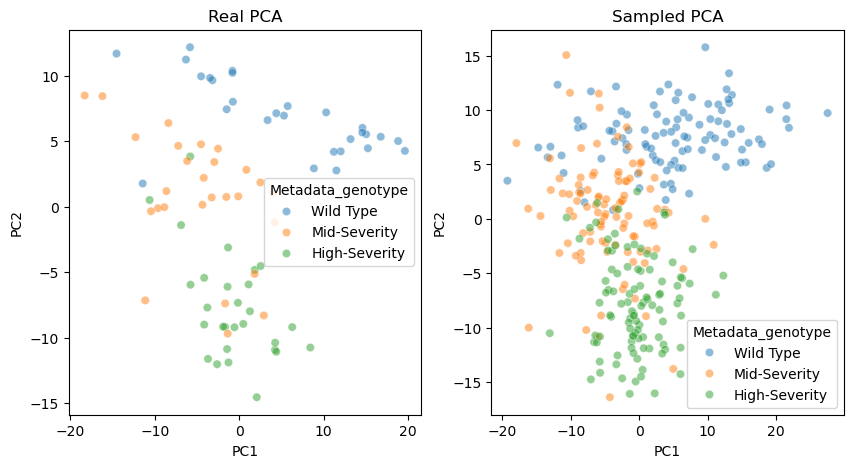

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=custom_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()